In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import glob
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
import warnings
warnings.simplefilter('ignore')
import time

In [2]:
data=xr.open_dataset('HadISST_ice.nc')*100
data1=xr.open_dataset('OISST_siconc_interpolated.nc').isel(zlev=0)*100
data2=xr.open_dataset('OSTIA_siconc_interpolated.nc')*100
data3=xr.open_dataset('siconc_hist_ssp126_50-p.nc')
data4=xr.open_dataset('all_heff.nc')
data5=xr.open_dataset('heff.1979.nc')
data6=xr.open_dataset('heff.H1979.nc')
data7=xr.open_dataset('sithick_SImon_IPSL-CM6A-LR_ssp126_r1i1p1f1_gn_201501-210012_can.nc')
data8=xr.open_dataset('c3s_obs-si_glo_phy_my_nh-l3_P1M_1721949305586.nc')

#data_10_ssp126_1982_2014=data2["sea_ice_fraction"].sel(time=slice("1982", "2014"))
data1_20_ssp126_1982_2014=data1["ice"].resample(time="MS").mean().sel(time=slice("1982", "2014"))
data_hadisst_1982_2014=data["sic"].resample(time="MS").mean().sel(time=slice("1982", "2014"))
data_hadisst_1982_2014=data3["siconc"].resample(time="MS").mean().sel(time=slice("1982", "2014"))

In [3]:
a=data8.groupby('time.season').mean('time').fillna(0)

In [5]:
a/a

<xarray.Dataset>
Dimensions:            (latitude: 451, longitude: 1800, season: 4)
Coordinates:
  * latitude           (latitude) float32 0.0 0.2 0.4 0.6 ... 89.6 89.8 90.0
  * longitude          (longitude) float32 -180.0 -179.8 -179.6 ... 179.6 179.8
  * season             (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sea_ice_thickness  (season, latitude, longitude) float32 nan nan ... nan nan

In [47]:
np.nanmin(a.sea_ice_thickness[1])

0.0

In [48]:
piomas=xr.open_dataset('PIOMAS_sithick_interpolated.nc')

In [49]:
pd_time = pd.date_range('1979-01-01', periods=540, freq='MS')

In [50]:
pd_time[:10]

DatetimeIndex(['1979-01-01', '1979-02-01', '1979-03-01', '1979-04-01',
               '1979-05-01', '1979-06-01', '1979-07-01', '1979-08-01',
               '1979-09-01', '1979-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [287]:
data4['time']=pd_time

In [522]:
data4

<xarray.Dataset>
Dimensions:     (time: 540, j: 120, i: 360, k: 30)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-12-01
Dimensions without coordinates: j, i, k
Data variables:
    month       (time) int16 1 2 3 4 5 6 7 8 9 10 11 ... 2 0 0 0 0 0 0 0 0 0 0
    lon_scaler  (j, i) float32 319.5 320.5 321.5 322.5 ... 317.9 318.4 318.8
    lat_scaler  (j, i) float32 48.99 48.99 48.99 48.99 ... 72.71 72.71 72.71
    z           (k) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    dz          (k) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    kmt         (j, i) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    dxt         (j, i) float32 68.38 68.38 68.38 68.38 ... 15.02 15.01 15.01
    dyt         (j, i) float32 72.47 72.47 72.47 72.47 ... 13.73 13.75 13.77
    heff        (time, j, i) float32 1e+04 1e+04 1e+04 1e+04 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:                                        Climate Data Interface versio...
    Conventions:                                CF-1.6
    Description:                                model/reanalysis output
    Model:                                      Panarctic Ice/Ocean Modeling ...
    generalized curvilinear coordinate system:  north pole of the model grid ...
    Reference:                                  Zhang, J., and D.A. Rothrock,...
    History:                                    created 1/18/2015 by J. Zhang...
    history:                                    Thu Aug 01 18:54:41 2024: cdo...
    CDO:                                        Climate Data Operators versio...

In [510]:
data4s=data4

In [405]:
piomas_data=data4
lon_min, lon_max =193, 343 #73W & 45W
lat_min, lat_max =14,89.97
#lon_min, lon_max =287, 315 #73W & 45W
#lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_pio = ((piomas_data.lat_scaler >= lat_min) & (piomas_data.lat_scaler<= lat_max) &
              (piomas_data.lon_scaler >= lon_min) & (piomas_data.lon_scaler <= lon_max))
piomas_data_region=piomas_data.where(mask_pio, drop=True)
piomas_data_region = piomas_data_region.where(piomas_data_region < 9999.9)

In [431]:
len(data4s.lon_scaler)

120

In [511]:
# Step 1: Define the dimensions
time_dim = 540  # Number of time steps
j_dim = 120     # j dimension size
i_dim = 360     # i dimension size

In [512]:
#Step 4: Flatten the lon and lat arrays for the interpolation step
lon_flat = data4s['lon_scaler'].values.flatten()
lat_flat = data4s['lat_scaler'].values.flatten()

# Create a 2D mesh grid for the target lat/lon grid
lon_new = np.linspace(lon_flat.min(), lon_flat.max(), j_dim)
lat_new = np.linspace(lat_flat.min(), lat_flat.max(), i_dim)
lon_grid, lat_grid = np.meshgrid(lon_new, lat_new)

In [513]:
# Step 5: Initialize an empty array for the interpolated thick data
thick_interp = np.empty((time_dim, i_dim, j_dim))

In [514]:
# Step 6: Perform the interpolation for each time step
start_time=time.time()
heff=data4s.where(data4s<9999.9)
for t in range(time_dim):
    thick_flat = heff.heff.isel(time=t).values.flatten()
    thick_interp[t, :, :] = griddata(
        (lon_flat, lat_flat), thick_flat, (lon_grid, lat_grid), method='linear'
    )
    
end_time=time.time()
elapsed_time = end_time - start_time
# Convert seconds to hours, minutes, seconds
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)
print("Execution time: ", hours, "hours,", minutes, "minutes,", seconds, "seconds")


Execution time:  0.0 hours, 6.0 minutes, 29.913418292999268 seconds


In [516]:
# Step 7: Create the final Dataset with the new dimensions
ds_final = xr.Dataset(
    {
        'heff': (['time', 'lat', 'lon'], thick_interp)
    },
    coords={
        'time': data4s.time,
        'lat': lat_new,
        'lon': lon_new
    }
)

ds_final=ds_final.interpolate_na(dim='lat', method='nearest').interpolate_na(dim='lon', method='nearest')

#ds_final.to_netcdf('heff_10.nc')

Execution time:  0.0 hours, 0.0 minutes, 23.45019817352295 seconds


In [517]:
lon_min, lon_max =193, 343 #73W & 45W
lat_min, lat_max =14,89.97
#lon_min, lon_max =287, 315 #73W & 45W
#lat_min, lat_max =51,69

# Create a mask for Labrador coast 
mask_final = ((ds_final.lat >= lat_min) & (ds_final.lat <= lat_max) &
              (ds_final.lon >= lon_min) & (ds_final.lon <= lon_max))
ds_final_region=ds_final.where(mask_final, drop=True)
#piomas_data_region = piomas_data_region.where(piomas_data_region < 9999.9)

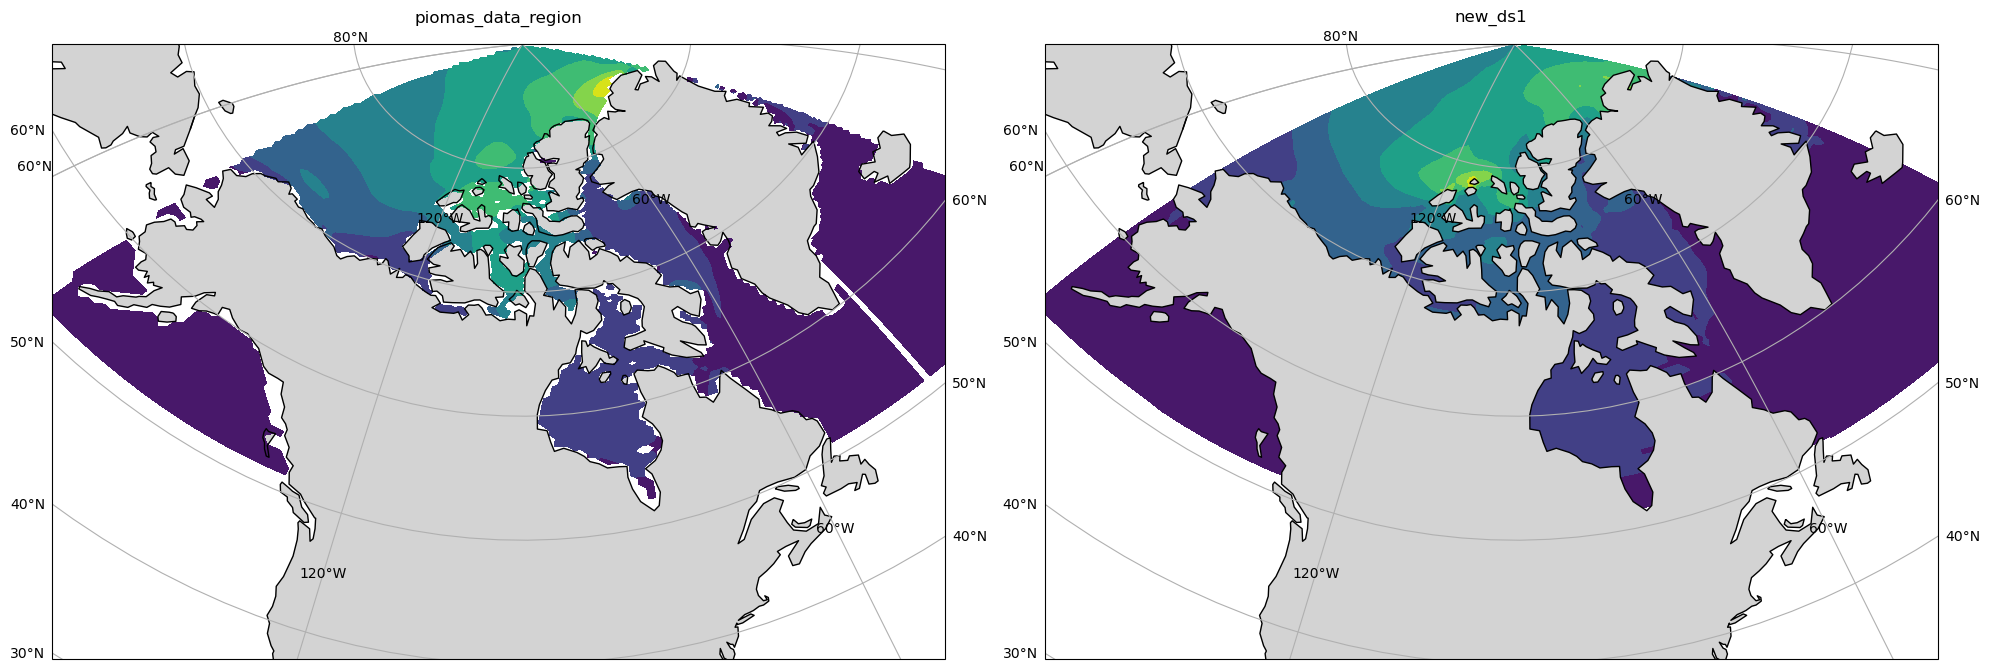

In [520]:
# Define your datasets
lons1 = piomas_data_region.lon_scaler
lats1 = piomas_data_region.lat_scaler
heff1 = piomas_data_region.heff[0]

lons2 = ds_final_region.lon
lats2 = ds_final_region.lat
heff2 = ds_final_region.heff[300]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': ccrs.RotatedPole(pole_longitude=83, pole_latitude=42.5)}, figsize=(20, 12))

# Plot the data from the first dataset
contour1 = ax1.contourf(lons1, lats1, heff1, transform=ccrs.PlateCarree(), cmap='viridis')
ax1.coastlines()
ax1.add_feature(cf.LAND, facecolor='lightgray')
ax1.set_extent([-150, -50, 40, 89.97], crs=ccrs.PlateCarree())
ax1.set_title('piomas_data_region')

# Plot the data from the second dataset
contour2 = ax2.contourf(lons2, lats2, heff2, transform=ccrs.PlateCarree(), cmap='viridis')
ax2.coastlines()
ax2.add_feature(cf.LAND, facecolor='lightgray', zorder=1)
ax2.set_extent([-150, -50, 40, 89.97], crs=ccrs.PlateCarree())
ax2.set_title('new_ds1')

# Add a colorbar for both plots
#cbar = plt.colorbar(contour1, ax=[ax1, ax2], orientation='vertical', pad=0.05, shrink=0.7)
#cbar.set_label('Sea Ice Thickness (heff)')

# Optionally, add gridlines
ax1.gridlines(draw_labels=True)
ax2.gridlines(draw_labels=True)

plt.tight_layout()
plt.show()

In [348]:
# Assuming 'ds' is your original dataset
# Here's the code to adjust the longitude values and create the new dataset:
ds=data4
# Create a new time range
time_new = pd.date_range(start='1979-01-01', end='2023-12-31', freq='MS')

# Replace the existing time dimension with the new one
ds = ds.assign_coords(time=time_new)

# 1. Extract the coordinates and variables from the original dataset
time = ds.time.values
lon_scaler = ds.lon_scaler.values
lat_scaler = ds.lat_scaler.values

# Flatten lon_scaler and lat_scaler to create coordinate arrays for the new dataset
lon_flattened = lon_scaler[100, :]  # Example: Flatten the first row for lon
lat_flattened = lat_scaler[:, 100]  # Example: Flatten the first column for lat

# Adjust the longitude values from 0-359 to -180 to 180
lon_adjusted = np.where(lon_flattened > 180, lon_flattened - 360, lon_flattened)

# Verify the shapes
print("Shape of lon_flattened:", lon_flattened.shape)
print("Shape of lat_flattened:", lat_flattened.shape)

# Create the new dataset with the extracted coordinates and original data
new_ds1 = xr.Dataset(
    {
        "heff": (("time", "lat", "lon"), ds.heff.values)
    },
    coords={
        "time": (("time"), time),
        "lat": (("lat"), np.sort(lat_flattened)),
        "lon": (("lon"), np.sort(lon_adjusted))
    }
)
new_ds1=new_ds1.where(new_ds1<9999.9)
# Print the new dataset to verify
print(new_ds1.lat.values)

Shape of lon_flattened: (360,)
Shape of lat_flattened: (120,)
[49.03 49.67 50.28 50.88 51.47 52.04 52.59 53.15 53.67 54.19 54.7  55.2
 55.68 56.15 56.64 57.1  57.55 57.99 58.43 58.86 59.29 59.7  60.12 60.52
 60.92 61.3  61.69 62.06 62.43 62.8  63.15 63.5  63.86 64.19 64.52 64.86
 65.19 65.51 65.82 66.14 66.46 66.75 67.04 67.33 67.63 67.92 68.22 68.52
 68.79 69.06 69.33 69.6  69.87 70.14 70.41 70.68 70.95 71.19 71.43 71.67
 71.91 72.15 72.39 72.62 72.86 73.09 73.33 73.56 73.79 74.02 74.24 74.46
 74.69 74.9  75.12 75.33 75.54 75.75 75.95 76.15 76.35 76.54 76.72 76.9
 77.08 77.25 77.42 77.58 77.74 77.88 78.03 78.16 78.29 78.41 78.53 78.64
 78.67 78.74 78.75 78.83 78.84 78.91 78.93 78.99 79.01 79.06 79.09 79.12
 79.15 79.17 79.2  79.22 79.24 79.25 79.27 79.28 79.3  79.3  79.31 79.31]


In [495]:
!cdo remapbil,model.txt heff_10.nc heff.nc


cdo    remapbil (Abort): Unsupported generic coordinates (Variable: heff)!


In [351]:
sic=data.sic
season= sic.groupby('time.season').mean('time')
sic = data['sic'] 
minimum_longitude=-167
maximum_longitude=-17
minimum_latitude=14
maximum_latitude=89.97

sic_canada=sic.sel(latitude=slice(maximum_latitude, minimum_latitude),
                   longitude=slice(minimum_longitude, maximum_longitude))

In [70]:
hb=pd.read_csv("polygon_bs_subarea_bs.csv", header=None, names=['lon', 'lat'])

In [71]:
# Convert longitudes to 0 to 360 range
#hb['lon'] = hb['lon'].apply(lambda lon: lon + 360 if lon < 0 else lon)

In [72]:
hudson_bay_polygon = Polygon(hb.values)

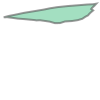

In [73]:
hudson_bay_polygon

In [81]:

# Create a Polygon object for Hudson Bay
hudson_bay_polygon = Polygon(hb.values)


# Extract the variable of interest
sic = data['sic']  # Replace 'variable_name' with the actual variable name

# Create a function to check if a point is within the Hudson Bay polygon
def is_in_hudson_bay(lon, lat):
    return Point(lon, lat).within(hudson_bay_polygon)

# Apply the function to create a mask
mask = xr.apply_ufunc(
    is_in_hudson_bay,
    sic['longitude'], sic['latitude'],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[bool]
)

In [12]:
sic

<xarray.DataArray 'sic' (time: 1851, latitude: 180, longitude: 360)>
array([[[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

In [82]:
# Use the mask to select the data within the Hudson Bay region
hudson_bay_data = sic.where(mask, drop=True)

In [83]:
np.min(hb['lon'])

-156.632613

In [84]:
hudson_bay_data

<xarray.DataArray 'sic' (time: 1851, latitude: 7, longitude: 33)>
array([[[      nan,       nan,       nan, ...,  98.     ,  97.     ,
          97.     ],
        [      nan,       nan,       nan, ...,  98.     ,  99.     ,
               nan],
        [      nan,       nan,       nan, ...,  95.     ,  94.     ,
               nan],
        ...,
        [ 97.     ,  97.     ,  99.     , ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,  98.     ,  97.     ,
          97.     ],
        [      nan,       nan,       nan, ...,  98.     , 100.     ,
               nan],
        [      nan,       nan,       nan, ...,  96.     ,  95.     ,
               nan],
...
        [ 98.99999,  97.99999, 100.     , ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,  98.99999,  98.99999,
          98.99999],
        [      nan,       nan,       nan, ...,  98.99999,  98.99999,
               nan],
        [      nan,       nan,       nan, ...,  98.99999,  98.99999,
               nan],
        ...,
        [100.     ,  97.99999,  98.99999, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2024-0...
  * latitude   (latitude) float32 75.5 74.5 73.5 72.5 71.5 70.5 69.5
  * longitude  (longitude) float32 -155.5 -154.5 -153.5 ... -125.5 -124.5 -123.5

In [16]:
data_hadisst_1982_2014=sic_canada.resample(time="MS").mean().sel(time=slice("1982","2014"))#

In [18]:
data_hadisst_1982_2014

<xarray.DataArray 'sic' (time: 396, latitude: 76, longitude: 150)>
array([[[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ...,  99.     ,  99.     ,
          99.     ],
        [100.     , 100.     , 100.     , ...,  98.     ,  98.     ,
          98.     ],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]],

       [[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ...,  99.     ,  99.     ,
          99.     ],
        [100.     , 100.     , 100.     , ...,  98.     ,  98.     ,
          98.     ],
...
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]],

       [[100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ..., 100.     , 100.     ,
         100.     ],
        [100.     , 100.     , 100.     , ...,  98.99999,  98.99999,
          98.99999],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... 17.5 16.5 15.5 14.5
  * longitude  (longitude) float32 -166.5 -165.5 -164.5 ... -19.5 -18.5 -17.5
  * time       (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2014-12-01

In [85]:
import xarray as xr

# Assuming data_10_ssp126_1982_2014, data_50_ssp126_1982_2014, data_90_ssp126_1982_2014,
# data_hadisst_1982_2014, data_ostia_1982_2014, and data_oisst_1982_2014 are already loaded

# Define the sub-regions with their latitude and longitude ranges
regions = {
    #'gom': {'lat': slice(39.93, 44.68), 'lon': slice(289.01, 294.25)},
    #'wss': {'lat': slice(42.14, 44.48), 'lon': slice(294.01, 296.01)},
    #'css': {'lat': slice(42.81, 44.92), 'lon': slice(296.01, 298.00)},
   # 'ess': {'lat': slice(42.99, 46.38), 'lon': slice(298.00, 302.81)},
    #'gsl': {'lat': slice(44.47, 51.78), 'lon': slice(292.79, 303.81)},
    #'sns': {'lat': slice(42.80, 47.80), 'lon': slice(301.64, 312.28)},
    #'cns': {'lat': slice(45.99, 49.25), 'lon': slice(305.51, 312.85)},
    #'nns': {'lat': slice(49.24, 52.25), 'lon': slice(303.27, 309.90)},
    #'sls': {'lat': slice(52.24, 57.66), 'lon': slice(298.30, 308.85)},
    #'nls': {'lat': slice(57.66, 61.00), 'lon': slice(295.50, 300.50)},
    'hb': {'lat': slice( 63.96,51.90), 'lon': slice(-94.69, -76.66)},
    #'bb': {'lat': slice(66.64, 78.58), 'lon': slice(277.81, 309.87)},
    #'bcs': {'lat': slice(47.82, 54.50), 'lon': slice(226.00, 237.49)}
}

# Function to compute yearly mean
def compute_yearly_mean(data):
    return data.resample(time='YS').mean()

# Subset each dataset for each region and compute yearly mean
yearly_means = {}

for region, bounds in regions.items():
    yearly_means[region] = {
        'data_hadisst': compute_yearly_mean(sic.sel(latitude=bounds['lat'], longitude=bounds['lon'])),
 }

# Now `yearly_means` contains the yearly mean datasets for each region


In [86]:
yearly_means['hb']

{'data_hadisst': <xarray.DataArray 'sic' (time: 155, latitude: 12, longitude: 18)>
 array([[[      nan,       nan,       nan, ..., 61.083332, 64.      ,
          69.666664],
         [      nan,       nan, 58.833332, ..., 56.666668, 57.333332,
          60.083332],
         [      nan, 57.      , 55.833332, ..., 55.25    , 54.166668,
                nan],
         ...,
         [      nan,       nan,       nan, ..., 49.      ,       nan,
                nan],
         [      nan,       nan,       nan, ..., 48.833332,       nan,
                nan],
         [      nan,       nan,       nan, ..., 49.333332,       nan,
                nan]],
 
        [[      nan,       nan,       nan, ..., 61.083332, 64.      ,
          69.666664],
         [      nan,       nan, 58.833332, ..., 56.666668, 57.333332,
          60.083332],
         [      nan, 57.      , 55.833332, ..., 55.25    , 54.166668,
                nan],
 ...
         [      nan,       nan,       nan, ..., 42.583332,       na

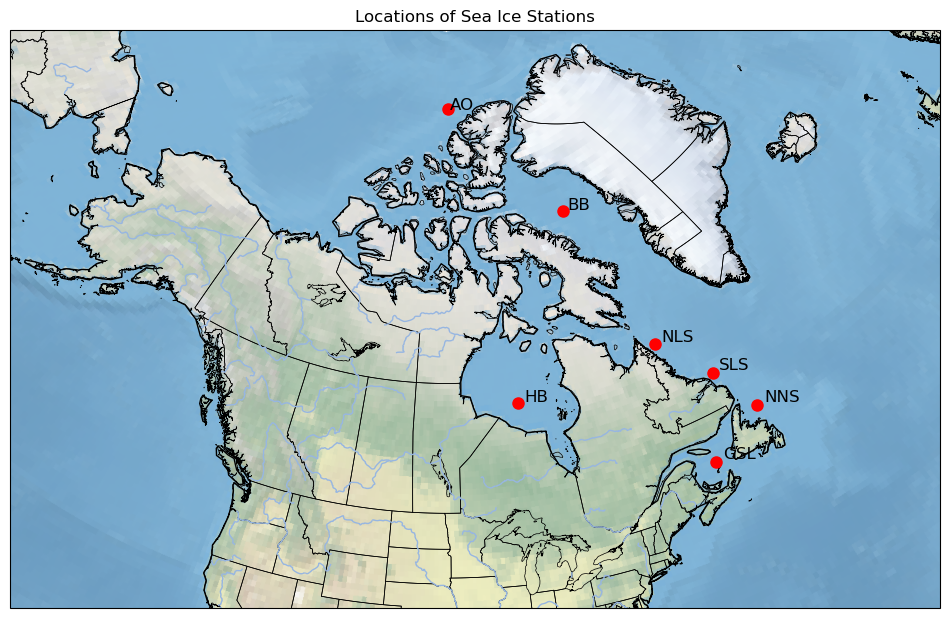

In [89]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

# Define the rotated pole projection
rotated_pole = ccrs.RotatedPole(pole_latitude=42.5, pole_longitude=83)

# Sub-regions with their latitude and longitude ranges
regions = {
    #'gom': {'lat': (39.93 + 44.68) / 2, 'lon': (-70.99 + -65.75) / 2},
    #'wss': {'lat': (42.14 + 44.48) / 2, 'lon': (-65.99 + -63.99) / 2},
    #'css': {'lat': (42.81 + 44.92) / 2, 'lon': (-63.99 + -62.00) / 2},
    #'ess': {'lat': (42.99 + 46.38) / 2, 'lon': (-62.00 + -57.19) / 2},
    'gsl': {'lat': (44.47 + 51.78) / 2, 'lon': (-67.21 + -56.19) / 2},
    #'sns': {'lat': (42.80 + 47.80) / 2, 'lon': (-58.36 + -47.72) / 2},
    #'cns': {'lat': (45.99 + 49.25) / 2, 'lon': (-54.49 + -47.15) / 2},
    'nns': {'lat': (49.24 + 52.25) / 2, 'lon': (-56.73 + -50.10) / 2},
    'sls': {'lat': (52.24 + 57.66) / 2, 'lon': (-61.7 + -51.15) / 2},
    'nls': {'lat': (57.66 + 61.00) / 2, 'lon': (-64.50 + -59.50) / 2},
    'hb': {'lat': (51.90 + 63.96) / 2, 'lon': (-94.69 + -76.66) / 2},
    'bb': {'lat': (66.64 + 78.58) / 2, 'lon': (-82.19 + -50.13) / 2},
    'ao': {'lat': (81.59 + 84.91) / 2, 'lon': (-111.95 + -79.78) / 2}

}
# Plot the data
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=rotated_pole)

# Add map features
ax.set_extent([-149, -37, 40.5, 89.97], crs=ccrs.PlateCarree())
ax.coastlines(zorder=2)
ax.add_feature(cf.LAND)
ax.add_feature(cf.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
ax.add_feature(cf.RIVERS.with_scale('50m'), zorder=2)
ax.add_feature(cf.OCEAN.with_scale('50m'), color='white')
ax.stock_img()


# Add the points for each station
for region, coords in regions.items():
    lat = coords['lat']
    lon = coords['lon']
    ax.plot(lon, lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + 1, lat, region.upper(), transform=ccrs.PlateCarree(), fontsize=12)

plt.title('Locations of Sea Ice Stations')
plt.show()


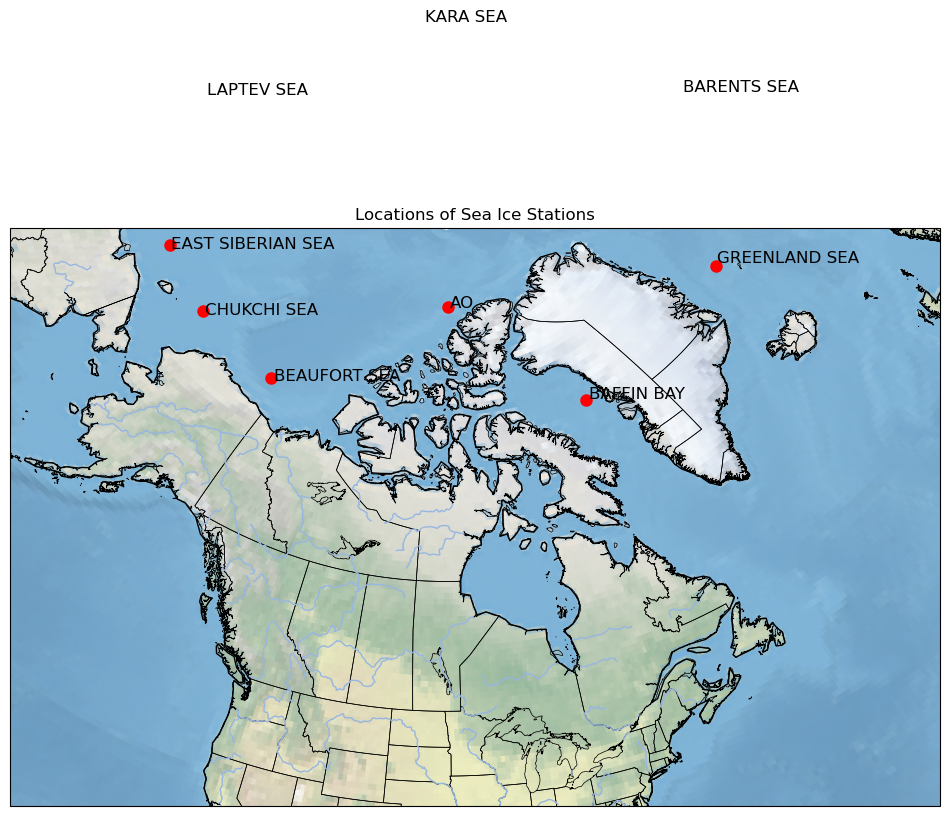

In [90]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

# Define the rotated pole projection
rotated_pole = ccrs.RotatedPole(pole_latitude=42.5, pole_longitude=83)

# Sub-regions with their latitude and longitude ranges
regions = {
    'Beaufort Sea': {'lat': (70 + 75) / 2, 'lon': (-160 + -130) / 2},
    'Chukchi Sea': {'lat': (70 + 75) / 2, 'lon': (-180 + -160) / 2},
    'East Siberian Sea': {'lat': (70 + 75) / 2, 'lon': (160 + 180) / 2},
    'Laptev Sea': {'lat': (70 + 75) / 2, 'lon': (110 + 140) / 2},
    'Kara Sea': {'lat': (70 + 75) / 2, 'lon': (60 + 110) / 2},
    'Barents Sea': {'lat': (70 + 75) / 2, 'lon': (20 + 60) / 2},
    'Greenland Sea': {'lat': (70 + 75) / 2, 'lon': (-40 + 20) / 2},
    'Baffin Bay': {'lat': (70 + 75) / 2, 'lon': (-80 + -40) / 2},
    'ao': {'lat': (81.59 + 84.91) / 2, 'lon': (-111.95 + -79.78) / 2}

}

rotated_pole = ccrs.RotatedPole(pole_latitude=42.5, pole_longitude=83)

# Plot the data
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=rotated_pole)

# Add map features
ax.set_extent([-149, -37, 40.5, 89.97], crs=ccrs.PlateCarree())
ax.coastlines(zorder=2)
ax.add_feature(cf.LAND)
ax.add_feature(cf.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
ax.add_feature(cf.RIVERS.with_scale('50m'), zorder=2)
ax.add_feature(cf.OCEAN.with_scale('50m'), color='white')
ax.stock_img()


# Add the points for each station
for region, coords in regions.items():
    lat = coords['lat']
    lon = coords['lon']
    ax.plot(lon, lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + 1, lat, region.upper(), transform=ccrs.PlateCarree(), fontsize=12)

plt.title('Locations of Sea Ice Stations')
plt.show()


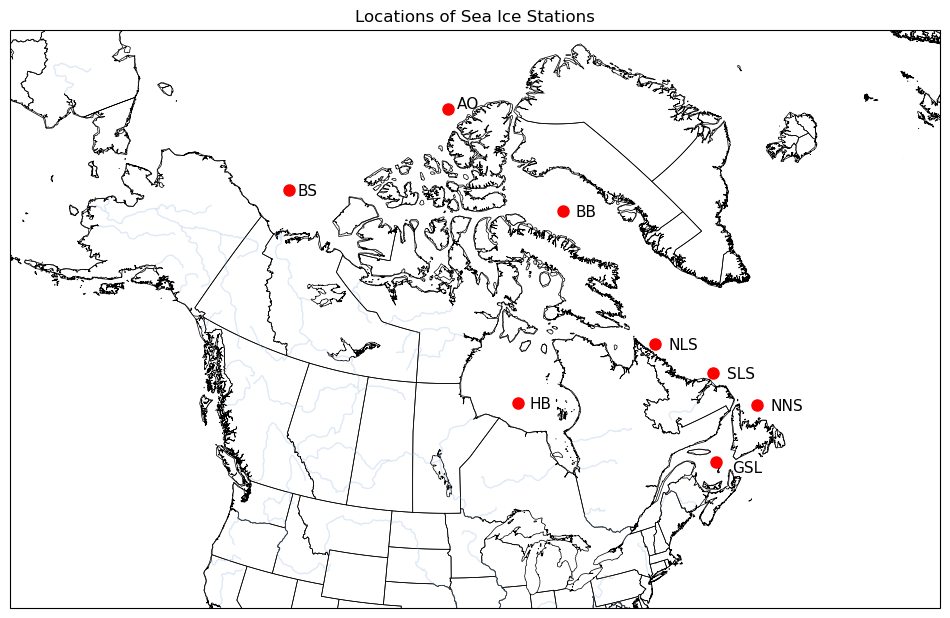

In [93]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

# Define the rotated pole projection
rotated_pole = ccrs.RotatedPole(pole_latitude=42.5, pole_longitude=83)

# Sub-regions with their latitude and longitude ranges and name offset

regions = {
    'gsl': {'lat': (44.47 + 51.78) / 2, 'lon': (-67.21 + -56.19) / 2, 'text_offset': (1.3, -1.4)},
    'nns': {'lat': (49.24 + 52.25) / 2, 'lon': (-56.73 + -50.10) / 2, 'text_offset': (1.1, -1.01)},
    'sls': {'lat': (52.24 + 57.66) / 2, 'lon': (-61.7 + -51.15) / 2, 'text_offset': (1.3, -1)},
    'nls': {'lat': (57.66 + 61.00) / 2, 'lon': (-64.50 + -59.50) / 2, 'text_offset': (1.5, -0.9)},
    'hb': {'lat': (51.90 + 63.96) / 2, 'lon': (-94.69 + -76.66) / 2, 'text_offset': (1.6, -0.6)},
    'bb': {'lat': (66.64 + 78.58) / 2, 'lon': (-82.19 + -50.13) / 2, 'text_offset': (2, -0.8)},
    'bs': {'lat': (69.09 + 76.20) / 2, 'lon': (-156.63 + -122.79) / 2,  'text_offset': (2.7, 0)},
    'ao': {'lat': (81.59 + 84.91) / 2, 'lon': (-111.95 + -79.78) / 2, 'text_offset':(5, 0)},
}

'''
other_regions = {
    'Beaufort Sea': {'lat': (70 + 75) / 2, 'lon': (-160 + -130) / 2},
    'Chukchi Sea': {'lat': (70 + 75) / 2, 'lon': (-180 + -160) / 2},
    'ao': {'lat': ( 85 + 87) / 2, 'lon': (-160 + -40) / 2}
}
'''
# Plot the data
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=rotated_pole)

# Add map features
ax.set_extent([-149, -37, 40.5, 89.97], crs=ccrs.PlateCarree())
ax.coastlines(zorder=2, linewidth=0.5)
#ax.add_feature(cf.LAND)
ax.add_feature(cf.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
ax.add_feature(cf.RIVERS.with_scale('50m'), zorder=2, alpha=0.3)
ax.add_feature(cf.OCEAN.with_scale('50m'), color='white')
#ax.stock_img()



# Add the points for each station and adjust label positions
for region, coords in regions.items():
    lat = coords['lat']
    lon = coords['lon']
    text_offset = coords['text_offset']
    
    ax.plot(lon, lat, marker='o', color='red', markersize=8, transform=ccrs.PlateCarree())
    ax.text(lon + text_offset[0], lat + text_offset[1], region.upper(), transform=ccrs.PlateCarree(), fontsize=11)
'''
for region, coords in other_regions.items():
    lat = coords['lat']
    lon = coords['lon']
    #text_offset = coords['text_offset']
   
    ax.plot(lon, lat, marker='o', color='blue', markersize=13, transform=ccrs.PlateCarree())
    ax.text(lon + text_offset[0], lat + text_offset[1], region.upper(), transform=ccrs.PlateCarree(), fontsize=11)

''' 
plt.title('Locations of Sea Ice Stations')
plt.show()


In [25]:
import csv

# Define polygons
regions = {
    "Beaufort Sea": [(75, -160), (75, -130), (70, -130), (70, -160)],
    "Chukchi Sea": [(75, -180), (75, -160), (70, -160), (70, -180)],
    "East Siberian Sea": [(75, 160), (75, 180), (70, 180), (70, 160)],
    "Laptev Sea": [(80, 120), (80, 140), (70, 140), (70, 120)],
    "Kara Sea": [(80, 60), (80, 120), (70, 120), (70, 60)],
    "Barents Sea": [(80, 20), (80, 60), (70, 60), (70, 20)],
    "Greenland Sea": [(80, -20), (80, 20), (70, 20), (70, -20)],
    "Canadian Archipelago": [(80, -110), (80, -60), (70, -60), (70, -110)],
    "Baffin Bay": [(80, -80), (80, -60), (70, -60), (70, -80)],
    "Fram Strait": [(80, -20), (80, 20), (78, 20), (78, -20)]
}

# Write to CSV
with open('arctic_regions.csv', 'w', newline='') as csvfile:
    fieldnames = ['Region', 'Latitude', 'Longitude']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for region, coordinates in regions.items():
        for lat, lon in coordinates:
            writer.writerow({'Region': region, 'Latitude': lat, 'Longitude': lon})

print("CSV file created successfully.")


CSV file created successfully.


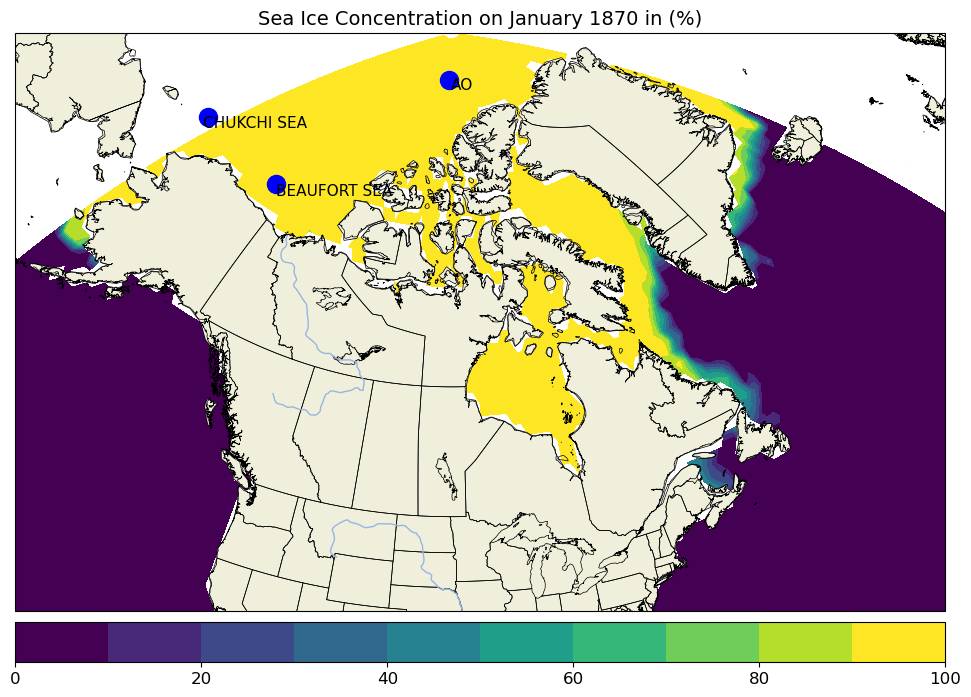

In [30]:
# Create a colormap and normalization
cmap = plt.cm.get_cmap('viridis', 10)
norm = colors.Normalize(vmin=0, vmax=100)  # Adjust vmin and vmax as per your data range

# Plot the data
fig = plt.figure(figsize=(12, 8))
# Define the rotated pole projection
rotated_pole = ccrs.RotatedPole(pole_latitude=42.5,pole_longitude=83)

ax = plt.axes(projection=rotated_pole)

# Add map features
ax.set_extent([-149, -37, 40.5, 89.97], crs=ccrs.PlateCarree())
ax.set_title('Sea Ice Concentration on January 1870 in (%)', fontsize=14)
ax.coastlines(zorder=2)
ax.add_feature(cf.LAND, zorder=2)
ax.add_feature(cf.STATES.with_scale('10m'), linewidth=0.5, zorder=2)
ax.add_feature(cf.RIVERS.with_scale('110m'), zorder=2)

# Plot sea ice concentration data using contourf
longitude, latitude = sic_canada.longitude, sic_canada.latitude
data = sic_canada[0]  # Select the first time step or any specific time step you need

contour = ax.contourf(longitude, latitude, data, transform=ccrs.PlateCarree(),
                      cmap=cmap, levels=10)

# Add colorbar
cbar_ax = fig.add_axes([0.125, 0.07, 0.775, 0.05])  # Adjust position and size as needed
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
for region, coords in other_regions.items():
    lat = coords['lat']
    lon = coords['lon']
    #text_offset = coords['text_offset']
    
    ax.plot(lon, lat, marker='o', color='blue', markersize=13, transform=ccrs.PlateCarree())
    ax.text(lon + text_offset[0], lat + text_offset[1], region.upper(), transform=ccrs.PlateCarree(), fontsize=11)

# Save plot to file and display
plt.savefig('sic.jpg', dpi=500, bbox_inches='tight')
plt.show()

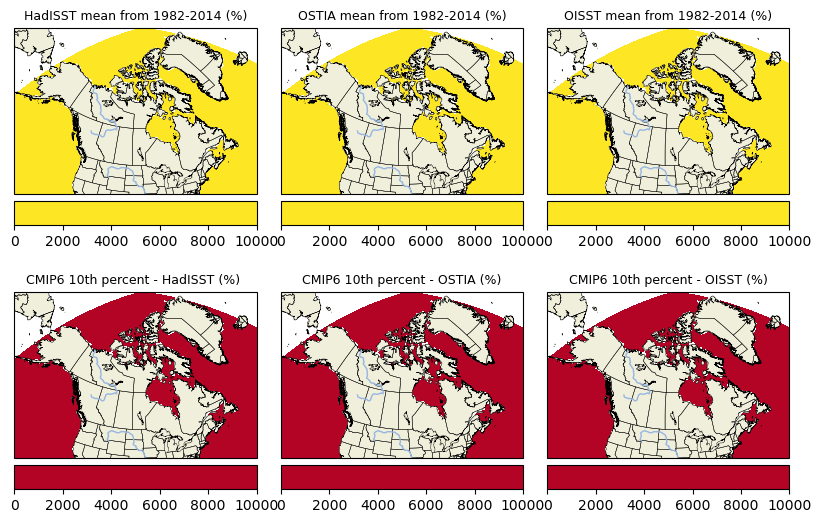

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming you have six data arrays in your data list
sic_canada_ = sic_canada.mean(dim='time')*100
data_list = [sic_canada_, sic_canada_, sic_canada_, sic_canada_, sic_canada_, sic_canada_]

# Create normalization
norm = colors.Normalize(vmin=0, vmax=100)  # Adjust vmin and vmax as per your data range

# Create a figure with adjusted aspect ratio for more square-like subplots
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': ccrs.RotatedPole(pole_longitude=83, pole_latitude=42.5)}, figsize=(10, 12))

# Titles for subplots
titles = ['HadISST mean from 1982-2014 (%)', 'OSTIA mean from 1982-2014 (%)', 'OISST mean from 1982-2014 (%)',
          'CMIP6 10th percent - HadISST (%) ','CMIP6 10th percent - OSTIA (%)', 'CMIP6 10th percent - OISST (%)']
          
# Plot each dataset in the list
for i, ax in enumerate(axs.flat):
    # Set the colormap based on the row index
    if i // 3 == 0:
        cmap = plt.cm.get_cmap('viridis', 10)
    else:
        cmap = plt.cm.get_cmap('coolwarm', 10)
    
    # Set the extent of the map
    ax.set_extent([-150, -50, 40, 89.97], crs=ccrs.PlateCarree())
    ax.set_title('Sea Ice Concentration on January 1870 in (%)', fontsize=14)
    ax.coastlines(zorder=2, linewidth=0.3)
    ax.add_feature(cf.BORDERS,linewidth=0.3)
    ax.add_feature(cf.LAND, zorder=2)
    ax.add_feature(cf.STATES.with_scale('10m'), linewidth=0.3, zorder=2)
    ax.add_feature(cf.RIVERS.with_scale('110m'), zorder=2)

    # Add map features
    contour = ax.contourf(data_list[i].longitude, data_list[i].latitude, data_list[i], transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=norm, levels=10)
    
    # Set title for each subplot
    ax.set_title(titles[i], fontsize=9)
    fig.colorbar(contour, ax=ax, orientation="horizontal", fraction=0.05, pad=0.01, aspect=10)
    #cbar.set_label('Sea Ice Concentration (%)')  # Add label to the colorbar

# Adjust layout to make subplots more square-like
plt.subplots_adjust( wspace=0.1, hspace=-0.6)

# Save plot to file and display
plt.savefig('sic_subplots.jpg', dpi=500, bbox_inches='tight')
plt.show()


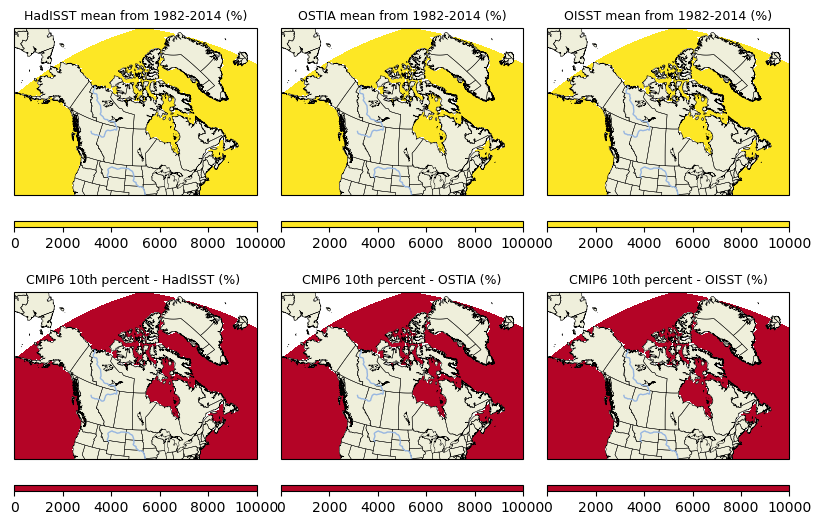

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming you have six data arrays in your data list
sic_canada_ = sic_canada.mean(dim='time') * 100
data_list = [sic_canada_, sic_canada_, sic_canada_, sic_canada_, sic_canada_, sic_canada_]

# Create a figure with adjusted aspect ratio for more square-like subplots
fig, axs = plt.subplots(2, 3, subplot_kw={'projection': ccrs.RotatedPole(pole_longitude=83, pole_latitude=42.5)}, figsize=(10, 12))

# Titles for subplots
titles = ['HadISST mean from 1982-2014 (%)', 'OSTIA mean from 1982-2014 (%)', 'OISST mean from 1982-2014 (%)',
          'CMIP6 10th percent - HadISST (%) ', 'CMIP6 10th percent - OSTIA (%)', 'CMIP6 10th percent - OISST (%)']

# Plot each dataset in the list
for i, ax in enumerate(axs.flat):
    # Set the colormap based on the row index
    if i // 3 == 0:
        cmap = plt.get_cmap('viridis', 10)
        norm = colors.Normalize(vmin=0, vmax=100)  # Adjust vmin and vmax as per your data range for the first row
    else:
        cmap = plt.get_cmap('coolwarm', 10)
        norm = colors.Normalize(vmin=-50, vmax=20)  # Adjust vmin and vmax as per your data range for the second row

    # Set the extent of the map
    ax.set_extent([-150, -50, 40, 89.97], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=2, linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3, zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('110m'), zorder=2)

    # Add map features
    contour = ax.contourf(data_list[i].longitude, data_list[i].latitude, data_list[i], transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=norm, levels=10)

    # Set title for each subplot
    ax.set_title(titles[i], fontsize=9)
    fig.colorbar(contour, ax=ax, orientation="horizontal", fraction=0.046, pad=0.04, aspect=40)

# Adjust layout to make subplots more square-like
plt.subplots_adjust(wspace=0.1, hspace=-0.6)

# Save plot to file and display
plt.savefig('sic_subplots.jpg', dpi=500, bbox_inches='tight')
plt.show()


In [40]:
sic_canada_year=sic.resample(time='YS').mean()

In [50]:
hbb=hudson_bay_data.mean(('time','latitude', 'longitude'))
bbb=hudson_bay_data.mean(('time','latitude', 'longitude'))
data=[hbb, bbb]
year = 2019

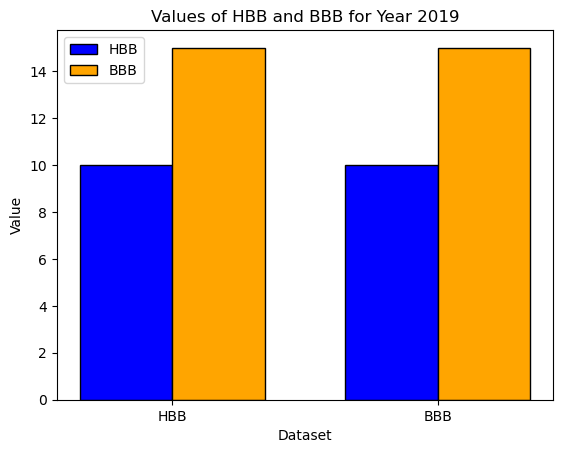

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
hbb = 10  # Replace with your actual data
bbb = 15  # Replace with your actual data
year = 2019

# Data for plotting
data = [hbb, bbb]
labels = ['HBB', 'BBB']

# Bar width
width = 0.35

# Position of bars on the x-axis
x = np.arange(len(labels))

# Create figure and axis
fig, ax = plt.subplots()

# Plot bars for each dataset
bars1 = ax.bar(x - width/2, [hbb], width, label='HBB', color='blue', edgecolor='black')
bars2 = ax.bar(x + width/2, [bbb], width, label='BBB', color='orange', edgecolor='black')

# Add titles and labels
ax.set_title(f'Values of HBB and BBB for Year {year}')
ax.set_xlabel('Dataset')
ax.set_ylabel('Value')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show plot
plt.show()


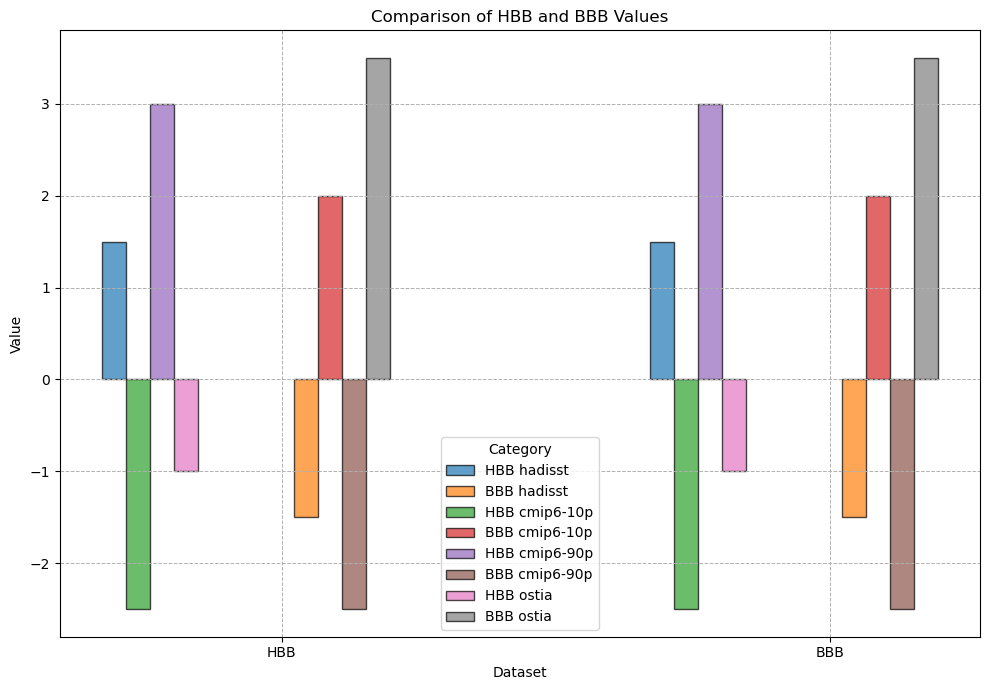

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data with negative values
categories = ['hadisst', 'cmip6-10p', 'cmip6-90p', 'ostia']
hbb_values = [1.5, -2.5, 3.0, -1.0]  # Replace with your actual data
bbb_values = [-1.5, 2.0, -2.5, 3.5]  # Replace with your actual data

# X-axis labels
x_labels = ['HBB', 'BBB']
num_categories = len(categories)
width = 0.35  # Width of each group of bars
x = np.arange(len(x_labels))  # The label locations

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Bar positions
bar_width = width / (num_categories * 2)  # Adjust width for grouped bars
for i, category in enumerate(categories):
    x_offset = (bar_width * (i + 1)) - (width / 2)
    ax.bar(x - width / 2 + x_offset, hbb_values[i], bar_width, label=f'HBB {category}', edgecolor='black', alpha=0.7)
    ax.bar(x + width / 2 + x_offset, bbb_values[i], bar_width, label=f'BBB {category}', edgecolor='black', alpha=0.7)

# Add titles and labels
ax.set_title('Comparison of HBB and BBB Values')
ax.set_xlabel('Dataset')
ax.set_ylabel('Value')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(title='Category')

# Show gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Show plot
plt.tight_layout()
plt.show()


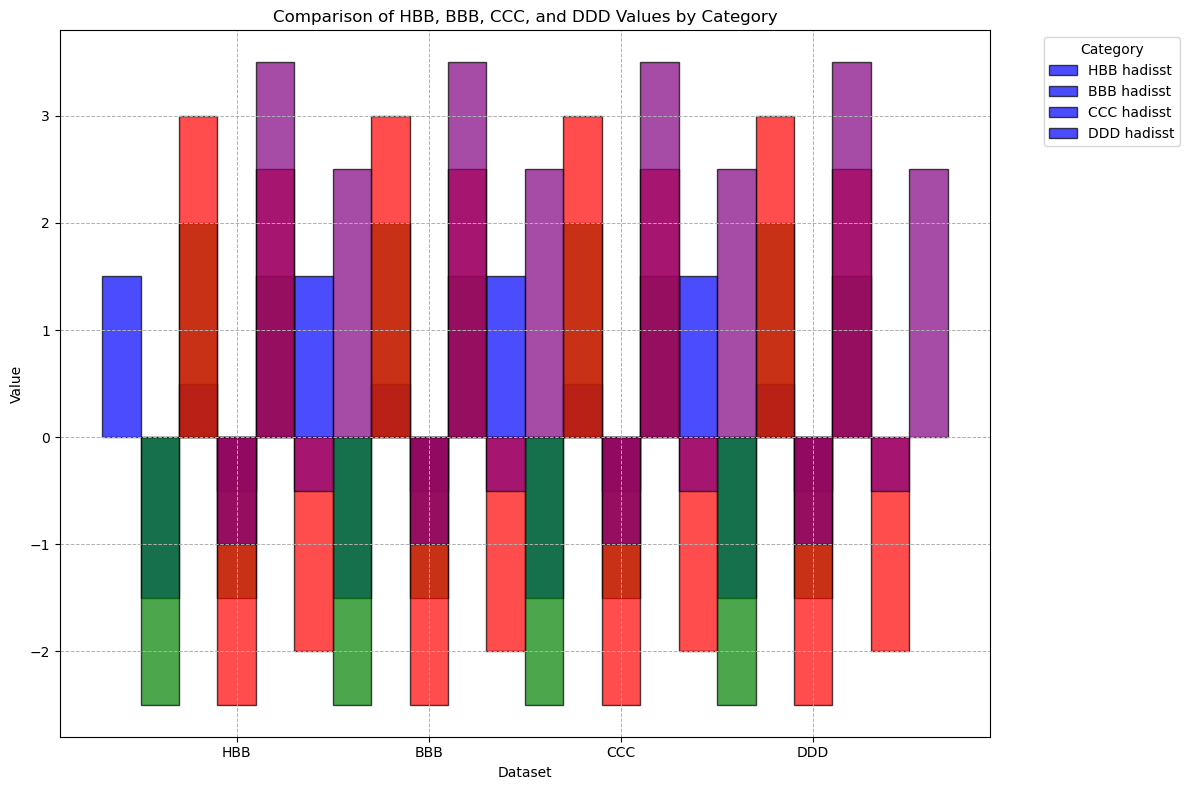

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for HBB, BBB, CCC, and DDD
categories = ['hadisst', 'cmip6-10p', 'cmip6-90p', 'ostia']
hbb_values = [1.5, -2.5, 3.0, -1.0]  # Replace with actual HBB data
bbb_values = [-1.5, 2.0, -2.5, 3.5]  # Replace with actual BBB data
ccc_values = [0.5, -1.5, 2.5, -0.5]  # Replace with actual CCC data
ddd_values = [-0.5, 1.5, -2.0, 2.5]  # Replace with actual DDD data

# X-axis labels
x_labels = ['HBB', 'BBB', 'CCC', 'DDD']
num_categories = len(categories)
width = 0.2  # Width of each bar

# Positions of bars on the x-axis
x = np.arange(len(x_labels))  # Position for each group

# Colors for each category
colors = ['blue', 'green', 'red', 'purple']

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Bar positions for each dataset
for i, category in enumerate(categories):
    x_offset = (i - (num_categories - 1) / 2) * width  # Offset for grouping bars
    ax.bar(x - width * 1.5 + x_offset, hbb_values[i], width, color=colors[i], edgecolor='black', alpha=0.7, label=f'HBB {category}' if i == 0 else "")
    ax.bar(x - width * 0.5 + x_offset, bbb_values[i], width, color=colors[i], edgecolor='black', alpha=0.7, label=f'BBB {category}' if i == 0 else "")
    ax.bar(x + width * 0.5 + x_offset, ccc_values[i], width, color=colors[i], edgecolor='black', alpha=0.7, label=f'CCC {category}' if i == 0 else "")
    ax.bar(x + width * 1.5 + x_offset, ddd_values[i], width, color=colors[i], edgecolor='black', alpha=0.7, label=f'DDD {category}' if i == 0 else "")

# Add titles and labels
ax.set_title('Comparison of HBB, BBB, CCC, and DDD Values by Category')
ax.set_xlabel('Dataset')
ax.set_ylabel('Value')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.7)

# Show plot
plt.tight_layout()
plt.show()


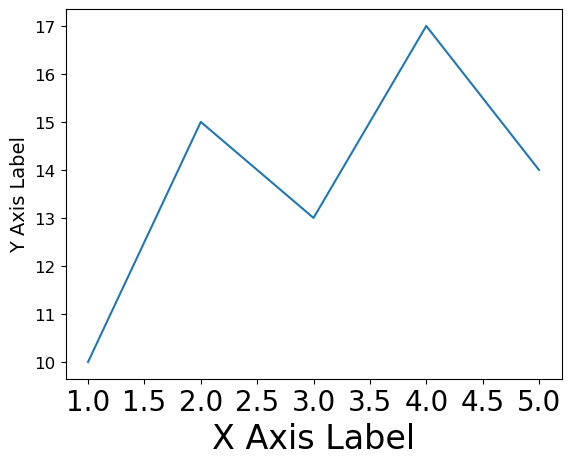

In [52]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 15, 13, 17, 14]

# Create the plot
plt.plot(x, y)

# Set the x-label and y-label with increased font size
plt.xlabel('X Axis Label', fontsize=24)
plt.ylabel('Y Axis Label', fontsize=14)

# Increase font size of tick labels on x-axis and y-axis
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


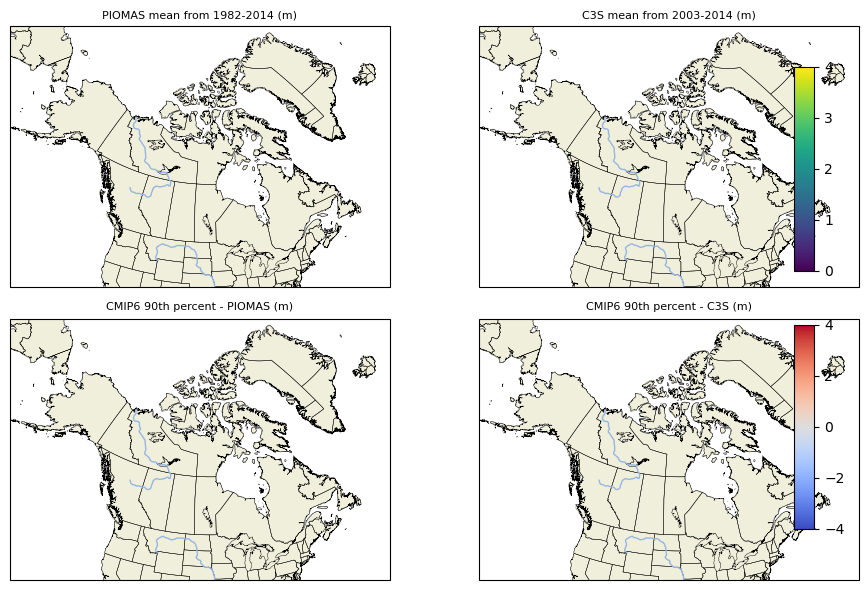

In [523]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Create normalization for the colorbars
norm_first_row = colors.Normalize(vmin=0, vmax=4)
norm_second_row = colors.Normalize(vmin=-4, vmax=4)  # Adjusted to have 0 as the mid-point

# Titles for subplots
titles = [
    'PIOMAS mean from 1982-2014 (m)',
    'C3S mean from 2003-2014 (m)',
    'CMIP6 90th percent - PIOMAS (m)',
    'CMIP6 90th percent - C3S (m)',
]

# Example data for demonstration
data_list = [np.random.rand(20, 20) * 4 for _ in range(2)] + [np.random.randn(20, 20) * 4 for _ in range(2)]

# Create figure and axes
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.RotatedPole(pole_longitude=83, pole_latitude=42.5)}, figsize=(10, 6))

# Plot each dataset in the list
for i, ax in enumerate(axs.flat):
    # Set the colormap and normalization based on the row index
    if i // 2 == 0:
        cmap = plt.get_cmap('viridis', 15)
        levels = np.round(np.linspace(0, 4, 15), 1)
        contour = ax.contourf(data_list[i], cmap=cmap, norm=norm_first_row, levels=levels, transform=ccrs.PlateCarree())
    else:
        cmap = plt.get_cmap('coolwarm', 15)
        levels = np.round(np.linspace(-4, 4, 15), 1)  # Adjusted to have 0 as the mid-point
        contour = ax.contourf(data_list[i], cmap=cmap, norm=norm_second_row, levels=levels, transform=ccrs.PlateCarree())

    ax.set_extent([-150, -50, 40, 89.97], crs=ccrs.PlateCarree())
    ax.coastlines(zorder=2, linewidth=0.3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3)
    ax.add_feature(cfeature.LAND, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.3, zorder=2)
    ax.add_feature(cfeature.RIVERS.with_scale('110m'), zorder=2)
    ax.set_title(titles[i], fontsize=8)

# Add colorbars for each row
cbar_ax1 = fig.add_axes([0.86, 0.54, 0.02, 0.34])  # Adjust these values as needed
cbar_ax2 = fig.add_axes([0.86, 0.11, 0.02, 0.34])  # Adjust these values as needed

# Plot the colorbars using the normalization and colormap
fig.colorbar(plt.cm.ScalarMappable(norm=norm_first_row, cmap='viridis'), cax=cbar_ax1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_second_row, cmap='coolwarm'), cax=cbar_ax2)

plt.tight_layout()
plt.show()


In [541]:
a=pd.read_csv('polygon_gsl_subarea_gsl.csv')

In [542]:
a

,-62.891663333333334,45.79265039215686
0,-62.924997,45.797226
1,-62.958330,45.802781
2,-62.991663,45.808337
3,-62.991663,45.808337
4,-63.024997,45.813465
...,...,...
1598,-62.791663,45.780559
1599,-62.824997,45.786114
1600,-62.858330,45.789587
1601,-62.889443,45.792446


In [58]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np

# Define your polygon using a list of (longitude, latitude) tuples
coords = [(-111.248194, 83.727954), (-108.611475, 83.935693), (-105.974757, 84.172382),
(-103.162257, 84.416992), (-99.998195, 84.601982), (-97.009914, 84.796826),
(-92.966945, 84.907230), (-89.099758, 84.552145), (-87.166165, 84.207970),
(-84.705227, 83.917094), (-82.420071, 83.631198), (-79.783353, 83.208328),
(-83.474759, 82.867486), (-87.166165, 82.600734), (-90.857571, 82.229575),
(-94.197414, 81.914428), (-98.591945, 81.586588), (-101.404445, 81.814929),
(-104.216945, 82.229575), (-107.029444, 82.690736), (-109.314600, 83.166626),
(-110.545069, 83.473288), (-111.951319, 83.611669)]  # Example coordinates
polygon = Polygon(coords)


# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon])

# Generate a grid of points within the polygon
minx, miny, maxx, maxy = polygon.bounds
x_points = np.linspace(minx, maxx, 50)  # 10 points along longitude
y_points = np.linspace(miny, maxy, 50)  # 10 points along latitude

points = []
for x in x_points:
    for y in y_points:
        point = Point(x, y)
        if polygon.contains(point):
            points.append(point)

points_gdf = gpd.GeoDataFrame(geometry=points)

In [34]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import numpy as np

# Define your polygon using a list of (longitude, latitude) tuples
coords = [(-156.632613, 71.239748), (-154.699019, 71.741943), (-152.150191, 72.231141),
          (-149.337691, 72.837793), (-145.909957, 73.399244), (-142.042769, 74.039783),
          (-139.757613, 74.516064), (-136.945113, 74.955673), (-132.990035, 75.360885),
          (-129.298629, 75.646879), (-126.134566, 75.906015), (-124.025191, 75.991371),
          (-122.794722, 76.202550), (-123.497847, 75.449472), (-124.288863, 74.725841),
          (-124.640425, 74.279682), (-123.937300, 73.747195), (-124.816207, 73.018407),
          (-125.519332, 72.311432), (-125.783004, 71.960951), (-126.749800, 71.464570),
          (-127.892379, 70.695215), (-129.562300, 70.195140), (-131.759566, 69.864960),
          (-134.220504, 69.713139), (-136.066207, 69.126166), (-137.911910, 69.094827),
          (-139.845504, 69.652104), (-143.361129, 70.165339), (-144.679488, 70.105609),
          (-145.382613, 70.224897), (-148.810347, 70.549408), (-151.447066, 70.753243),
          (-153.732222, 71.069408), (-155.314253, 71.267994)]  # Example coordinates
polygon = Polygon(coords)


# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon])

# Generate a grid of points within the polygon
minx, miny, maxx, maxy = polygon.bounds
x_points = np.linspace(minx, maxx, 50)  # 10 points along longitude
y_points = np.linspace(miny, maxy, 50)  # 10 points along latitude

points = []
for x in x_points:
    for y in y_points:
        point = Point(x, y)
        if polygon.contains(point):
            points.append(point)

points_gdf = gpd.GeoDataFrame(geometry=points)
points_gdf['lon']=points_gdf.geometry.x
points_gdf['lat']=points_gdf.geometry.y
a=points_gdf[['lon','lat']]
# Assuming df is your DataFrame
a.to_csv('polygon_bs_subarea_bs.csv', index=False, header=False)

                         geometry
0     POINT (-155.94204 71.27066)
1     POINT (-155.94204 71.41572)
2     POINT (-155.25147 71.27066)
3     POINT (-155.25147 71.41572)
4     POINT (-155.25147 71.56077)
...                           ...
1215  POINT (-123.48529 75.47727)
1216  POINT (-123.48529 75.62233)
1217  POINT (-123.48529 75.76738)
1218  POINT (-123.48529 75.91244)
1219  POINT (-123.48529 76.05749)

[1220 rows x 1 columns]


In [61]:
coords1 = [(-111.248194, 83.727954), (-108.611475, 83.935693), (-105.974757, 84.172382),
(-103.162257, 84.416992), (-99.998195, 84.601982), (-97.009914, 84.796826),
(-92.966945, 84.907230), (-89.099758, 84.552145), (-87.166165, 84.207970),
(-84.705227, 83.917094), (-82.420071, 83.631198), (-79.783353, 83.208328),
(-83.474759, 82.867486), (-87.166165, 82.600734), (-90.857571, 82.229575),
(-94.197414, 81.914428), (-98.591945, 81.586588), (-101.404445, 81.814929),
(-104.216945, 82.229575), (-107.029444, 82.690736), (-109.314600, 83.166626),
(-110.545069, 83.473288), (-111.951319, 83.611669)]  # Example coordinates

df = pd.DataFrame(coords1, columns=['lon', 'lat'])

In [63]:
new_df=df[['lon','lat']]
# Assuming df is your DataFrame
new_df.to_csv('polygon_ao_subarea_ao.csv', index=False, header=False)

In [68]:
coords2 = [(-156.632613, 71.239748), (-154.699019, 71.741943), (-152.150191, 72.231141),
          (-149.337691, 72.837793), (-145.909957, 73.399244), (-142.042769, 74.039783),
          (-139.757613, 74.516064), (-136.945113, 74.955673), (-132.990035, 75.360885),
          (-129.298629, 75.646879), (-126.134566, 75.906015), (-124.025191, 75.991371),
          (-122.794722, 76.202550), (-123.497847, 75.449472), (-124.288863, 74.725841),
          (-124.640425, 74.279682), (-123.937300, 73.747195), (-124.816207, 73.018407),
          (-125.519332, 72.311432), (-125.783004, 71.960951), (-126.749800, 71.464570),
          (-127.892379, 70.695215), (-129.562300, 70.195140), (-131.759566, 69.864960),
          (-134.220504, 69.713139), (-136.066207, 69.126166), (-137.911910, 69.094827),
          (-139.845504, 69.652104), (-143.361129, 70.165339), (-144.679488, 70.105609),
          (-145.382613, 70.224897), (-148.810347, 70.549408), (-151.447066, 70.753243),
          (-153.732222, 71.069408), (-155.314253, 71.267994)]  # Example coordinates

df2 = pd.DataFrame(coords2, columns=['lon', 'lat'])

In [69]:
new_df2=df2[['lon','lat']]
# Assuming df is your DataFrame
new_df2.to_csv('polygon_bs_subarea_bs.csv', index=False, header=False)

In [79]:
print('ao')
print('==========')
print(f'max_lon: {np.max(df.lon)}')
print(f'min_lon: {np.min(df.lon)}')
print(f'max_lat: {np.max(df.lat)}')
print(f'min_lat: {np.min(df.lat)}')

ao
max_lon: -79.783353
min_lon: -111.951319
max_lat: 84.90723
min_lat: 81.586588


In [80]:
print('bs')
print('==========')
print(f'max_lon: {np.max(df2.lon)}')
print(f'min_lon: {np.min(df2.lon)}')
print(f'max_lat: {np.max(df2.lat)}')
print(f'min_lat: {np.min(df2.lat)}')

bs
max_lon: -122.794722
min_lon: -156.632613
max_lat: 76.20255
min_lat: 69.094827
